# Credit Risk Project

First and foremost the goal is to learn about credit risk and applying machine learning and analysis.

We need a data set to work with. I am going to look on Kaggle.

Before starting, I am going to lay out some stuff I know about credit risk and how machine learning applies. First credit risk is quantifying or decidimg how risky it is to loan out money to a person or organization based on the information on their application. Some ML algorithms that would be useful would be supervised learning to help the algorithm make decisions on whether to give a loan to someone based on their labels of past successful or unsuccessful algorithms. ML algorithms that work well with tabular data like XGBoost or Random Forest would be good for this situation. Unsupervised algorithms would be use in order to group applications into certain categories without specifically specifying their labels. They would be group on how similar they are to other. Classification algorithms are the way to go on this one (I think... I haven't seen the data). Specifically Logistical Classification helps with probability of a grant or maybe even supper vector machines that could split the accepted vs unaccepted applications. Knowing all this so far let's do some EDA and figure it out from there. 

In [267]:
import kagglehub

# Download latest versionc:\Users\ty725\.cache\kagglehub\datasets\wordsforthewise\lending-club\versions\3
path = kagglehub.dataset_download("wordsforthewise/lending-club")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ty725\.cache\kagglehub\datasets\wordsforthewise\lending-club\versions\3


In [107]:
path = "C:\\Users\\ty725\.cache\kagglehub\\datasets\wordsforthewise\\lending-club\\versions\\3"
path1 = path + "\\accepted_2007_to_2018q4.csv\\accepted_2007_to_2018Q4.csv"
path2 = path + "\\rejected_2007_to_2018q4.csv\\rejected_2007_to_2018Q4.csv"

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\ty725\AppData\Local\Temp\ipykernel_36748\25542923.py:1: SyntaxWarning: invalid escape sequence '\.'
  path = "C:\\Users\\ty725\.cache\kagglehub\\datasets\wordsforthewise\\lending-club\\versions\\3"


Okay these datasets are huge! I think this is a good oppurtunity to use PySpark. I heard that it works really well with huge datasets. 

## Dataset EDA

In [108]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# Start new session
spark = SparkSession.builder \
    .appName("NewSession") \
    .getOrCreate()

In [109]:
dfa = spark.read.csv(path1, header=True)

Ok so there's a one thing to notice other than the amount of rows being huge: the columns are very different for the rejected pile vs the accepted pile. The accepted pile includes way more information about the actual loan that give out as well. So before we start cleaning, we have to figure which of the most important features/columns we need to clean. The best way to do that is to figure out which of the columns match because the goal is to get the accepted and the reject in one pile for the ML algo. 

After some inspiration, I understand how I am supposed to approach this problem. Focus on only accepted loans to predict the probability of default among accepted loans. The key column here is the loan status, mainly between statuses "Charged Off" vs "Fully Paid".

Ok so the next step is to load it on to the cloud and query it so we can get a dirty dataset. We'll use PySpark to clean it on the occasion that the dataset is still huge.

In [110]:
dfa.createOrReplaceTempView('loans')

In [111]:
df = spark.sql('''
    SELECT * FROM loans
    WHERE loan_status = 'Charged Off' OR  loan_status = 'Fully Paid' 
               OR loan_status = 'Default'
''')
df.show()

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

In [112]:
df = df.withColumn(
    "loan_status",
    when(df.loan_status.isin("Charged Off", "Default"), "Charged Off")
    .otherwise("Fully Paid")
)

In [114]:
#df.describe().show()

In [115]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- funded_amnt: string (nullable = true)
 |-- funded_amnt_inv: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = false)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string

In [116]:
rows = df.count()
rows

1345349

In [117]:
from pyspark.sql.functions import col, isnull, sum

def nullCount(dft):
    nullCounts = dft.agg(*[
        ((sum(isnull(col(c)).cast('integer')) / rows) * 100).alias(c)
        for c in dft.columns
    ])
    nullCounts.show()

nullCount(df)

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+-----------------+------------------+--------------+----------+-------------------+-------+-----------+----------+---+-----------------+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+------------------+--------------------+-----------------+--------------------+--------------------+-------------------+--------------------------+---------------------------+--------------------+----------------

I know I keep saying this but this dataset really is huge. My first approach was to go through each of attributes, figure out what they mean, and then figure out if they are useful. The thing is there is 151 attributes and I don't have all night here. We can't have a lot of attributes because this can cause the model to overfit, the key is generalization for a good ML model. So instead of getting 151 attributes down to 20 or so, it's better to hand pick the key features we need for our model and then clean that.

In [118]:
features = '''
id, loan_status, loan_amnt, int_rate, installment, grade, sub_grade, emp_length,
home_ownership, annual_inc, verification_status, purpose, dti, delinq_2yrs, 
inq_last_6mths, fico_range_low, fico_range_high, total_pymnt
'''

def cleanStrings(strings):
    strings = strings.split(',')
    for i, string in enumerate(strings):
        strings[i] = string.strip()
    return strings



In [119]:
features = cleanStrings(features)
df = df.select(features)

In [120]:
#df.toPandas()

## Data Cleaning 

In [121]:
df.show(5)

+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+------------------+
|      id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|       total_pymnt|
+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+------------------+
|68407277| Fully Paid|   3600.0|   13.99|     123.03|    C|       C4| 10+ years|      MORTGAGE|   55000.0|       Not Verified|debt_consolidation| 5.91|        0.0|           1.0|         675.0|          679.0| 4421.723916800001|
|68355089| Fully Paid|  24700.0|   11.99|     820.28|    C|       C1| 10+ years|    

In [122]:
nullCount(df)

+---+-----------+---------+--------+-----------+-----+---------+------------------+--------------+----------+-------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|        emp_length|home_ownership|annual_inc|verification_status|purpose|                 dti|         delinq_2yrs|      inq_last_6mths|      fico_range_low|     fico_range_high|         total_pymnt|
+---+-----------+---------+--------+-----------+-----+---------+------------------+--------------+----------+-------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|0.0|        0.0|      0.0|     0.0|        0.0|  0.0|      0.0|5.8361064675411365|           0.0|       0.0|                0.0|    0.0|0.027873808208873686|7.433015522366315E-5|1.486603104473263E-4|7.433015

Ok all missing values seems to be under 6% so it safe to drop all the rows that have a missing values. This saves a massive headache. Now there is something to note. Looking at the data, I assumed that if they're missing employment length, then that must mean that they're unemployed. Using data wrangler, some people have job titles but no employment length, so the unemployment assumption is not always valid. This is kind of significant to note becase employment length has the highest null count of 6%, everything else is less significant. Any ways, we'll drop any rows with missing cells, this dataset is huge.

In [123]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- loan_status: string (nullable = false)
 |-- loan_amnt: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- fico_range_low: string (nullable = true)
 |-- fico_range_high: string (nullable = true)
 |-- total_pymnt: string (nullable = true)



In [124]:
colsFloats ='loan_amnt, int_rate, installment, annual_inc, dti, total_pymnt'
colsInts = 'delinq_2yrs, fico_range_low, fico_range_high, inq_last_6mths'

colsFloats = cleanStrings(colsFloats)
colsInts = cleanStrings(colsInts)

for column in colsFloats:
    df = df.withColumn(column, col(column).cast('float'))

for column in colsInts:
    df = df.withColumn(column, col(column).cast('int'))

In [125]:
df = df.na.drop()
rows = df.count()
nullCount(df)

+---+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+---+-----------+--------------+--------------+---------------+-----------+
| id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|purpose|dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|total_pymnt|
+---+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+---+-----------+--------------+--------------+---------------+-----------+
|0.0|        0.0|      0.0|     0.0|        0.0|  0.0|      0.0|       0.0|           0.0|       0.0|                0.0|    0.0|0.0|        0.0|           0.0|           0.0|            0.0|        0.0|
+---+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+---+-----------+--------------+--------------+---------

In [126]:
rows = df.count()
rows

1266592

In [127]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- loan_status: string (nullable = false)
 |-- loan_amnt: float (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- fico_range_low: integer (nullable = true)
 |-- fico_range_high: integer (nullable = true)
 |-- total_pymnt: float (nullable = true)



Ok so we're going to try something. We're going to apply One Hot Encoder becase we have some attributes that cannot be easily converted clean numbers for the algo to understand. One Hot Encoder is good for categorical data, namely in this case: loan_status, grade, sub_grade, emp_length (maybe, there's still hope for this one), home_ownership, verification_status, and purpose.

In [128]:
df = df.filter(col('home_ownership') != 'ANY')

In [129]:
otherInfo = df.filter(col('home_ownership') == 'OTHER').groupBy('loan_status').count()
otherInfo

DataFrame[loan_status: string, count: bigint]

In [130]:
NoneInfo =  df.filter(col('home_ownership') == 'NONE').groupBy('loan_status').count()
NoneInfo

DataFrame[loan_status: string, count: bigint]

In [131]:
common_owners = ["RENT", "OWN", "MORTGAGE"]

df = df.withColumn(
    "home_ownership",
    when(col("home_ownership").isin(common_owners), col("home_ownership"))
    .otherwise("OTHER")
)

In [132]:
encodedCols = 'loan_status, emp_length, home_ownership, verification_status, purpose'
encodedCols = cleanStrings(encodedCols)
encodedCols

['loan_status',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose']

In [133]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

stages = []
for c in encodedCols:
    indexer = StringIndexer(inputCol = c, outputCol = c + '_')
    encoder = OneHotEncoder(inputCol = c + '_', outputCol = c + '-', dropLast = True)
    stages += [indexer, encoder]

pipeline = Pipeline(stages=stages)
encoded_df = pipeline.fit(df).transform(df)

In [134]:
encoded_df.show(5)

+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+-----------+------------+-------------+-----------+--------------+---------------+---------------+--------------------+--------------------+--------+--------------+
|      id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|total_pymnt|loan_status_| loan_status-|emp_length_|   emp_length-|home_ownership_|home_ownership-|verification_status_|verification_status-|purpose_|      purpose-|
+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+-----------+------------+-------------+----

In [135]:
empInfo = encoded_df.groupBy("emp_length").count()
empInfo

DataFrame[emp_length: string, count: bigint]

In [136]:
empLoanInfo = encoded_df.groupBy("emp_length", "loan_status").count()
empLoanInfo

DataFrame[emp_length: string, loan_status: string, count: bigint]

In [137]:
import pandas as pd
empLoanInfo = empLoanInfo.toPandas()

In [138]:
def pivotIt(dft, index):
    pivot = dft.pivot_table(index = index, columns = "loan_status", values = "count", aggfunc = "sum")
    pivot['total'] = pivot.loc[:, 'Charged Off'] + pivot.loc[:, 'Fully Paid']
    pivot['default_percentage'] = (pivot.loc[:, 'Charged Off'] / pivot['total']) * 100
    return pivot.sort_values(ascending = True, by = 'default_percentage')

In [139]:
pivotIt(empLoanInfo, "emp_length")

loan_status,Charged Off,Fully Paid,total,default_percentage
emp_length,,,,
10+ years,83047,359045,442092,18.785004
6 years,12139,50571,62710,19.357359
7 years,11615,47989,59604,19.486947
5 years,16485,67621,84106,19.600266
4 years,15894,64615,80509,19.741892
2 years,24110,97588,121698,19.811336
9 years,10135,40786,50921,19.903380
8 years,12101,48591,60692,19.938377
3 years,21483,86065,107548,19.975267


With emp_length, after some data analysis I found that the difference is between 10+ and <1 is 1.75% (with 10+ having a lower charged off percentage), but the range between all the other numbers (2-9) was 0.6% and they were pretty random in order. Based on my findings I think I should use One Hot Encoding because the linear progression at least for the middle numbers is none existent. For the remaining columns (grade and subgrade) needs to be encoded in ordinally which basically means that the order matters when encoding. 

In [140]:
grade_df = encoded_df.groupBy("grade", "loan_status").count().toPandas()
pivotIt(grade_df, "grade")

loan_status,Charged Off,Fully Paid,total,default_percentage
grade,,,,
A,12795,209530,222325,5.755088
B,47961,321888,369849,12.967725
C,78814,280035,358849,21.962998
D,56205,131782,187987,29.898344
E,33680,54570,88250,38.164306
F,13620,16764,30384,44.826224
G,4300,4381,8681,49.533464


In [141]:
subgrade_df = encoded_df.groupBy("sub_grade", "loan_status").count().toPandas()
pivotIt(subgrade_df, "sub_grade")

loan_status,Charged Off,Fully Paid,total,default_percentage
sub_grade,,,,
A1,1243,39975,41218,3.015673
A2,1532,33576,35108,4.363678
A3,1851,34059,35910,5.154553
A4,3238,46082,49320,6.565288
A5,4931,55838,60769,8.114335
B1,6696,60318,67014,9.991942
B2,7636,62017,69653,10.962916
B3,9712,67472,77184,12.582919
B4,11317,67136,78453,14.425197


This confirms the decision for Ordinal Encoding.

In [142]:
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
levels = [1,2,3,4,5]
submap = {}
k = 0
ran = len(grades) * len(levels)
for i in range(len(grades)):
    for j in range(len(levels)):
        submap[grades[i] + str(levels[j])] = k
        k += 1
        
map = {}
for i in range(len(grades)):
    map[grades[i]] = i

In [143]:
from pyspark.sql.functions import lit
encoded_df = encoded_df.withColumn('sub_grade-', lit(None))
encoded_df = encoded_df.withColumn('grade-', lit(None))

for value, key in enumerate(map):
    encoded_df = encoded_df.withColumn('grade-', when(col("grade") == lit(key), value).otherwise(col("grade-")))

for value, key in enumerate(submap):
    encoded_df = encoded_df.withColumn('sub_grade-', when(col("sub_grade") == lit(key), value).otherwise(col("sub_grade-")))


In [144]:
encoded_df.show(5)

+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+-----------+------------+-------------+-----------+--------------+---------------+---------------+--------------------+--------------------+--------+--------------+----------+------+
|      id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|total_pymnt|loan_status_| loan_status-|emp_length_|   emp_length-|home_ownership_|home_ownership-|verification_status_|verification_status-|purpose_|      purpose-|sub_grade-|grade-|
+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+-------

In [145]:
col_names = '''id, loan_status-, loan_amnt, int_rate, installment, grade-, sub_grade-, 
emp_length-, home_ownership-, annual_inc, verification_status-, purpose-, dti, 
delinq_2yrs, inq_last_6mths, fico_range_low, fico_range_high, total_pymnt
'''
col_names = cleanStrings(col_names)
df = encoded_df.select(col_names)
df.show(5)

+--------+-------------+---------+--------+-----------+------+----------+--------------+---------------+----------+--------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
|      id| loan_status-|loan_amnt|int_rate|installment|grade-|sub_grade-|   emp_length-|home_ownership-|annual_inc|verification_status-|      purpose-|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|total_pymnt|
+--------+-------------+---------+--------+-----------+------+----------+--------------+---------------+----------+--------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
|68407277|(1,[0],[1.0])|   3600.0|   13.99|     123.03|     2|        13|(10,[0],[1.0])|  (3,[0],[1.0])|   55000.0|       (2,[1],[1.0])|(13,[0],[1.0])| 5.91|          0|             1|           675|            679|   4421.724|
|68355089|(1,[0],[1.0])|  24700.0|   11.99|     820.28|     2|        10|(10,[0],[1.0])|

In [146]:
for i in range(len(col_names)):
    df = df.withColumnRenamed(col_names[i], features[i])   

In [147]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- loan_status: vector (nullable = true)
 |-- loan_amnt: float (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sub_grade: integer (nullable = true)
 |-- emp_length: vector (nullable = true)
 |-- home_ownership: vector (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: vector (nullable = true)
 |-- purpose: vector (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- fico_range_low: integer (nullable = true)
 |-- fico_range_high: integer (nullable = true)
 |-- total_pymnt: float (nullable = true)



In [148]:
df.count()

1266325

In [149]:
df.show(5)

+--------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
|      id|  loan_status|loan_amnt|int_rate|installment|grade|sub_grade|    emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|total_pymnt|
+--------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
|68407277|(1,[0],[1.0])|   3600.0|   13.99|     123.03|    2|       13|(10,[0],[1.0])| (3,[0],[1.0])|   55000.0|      (2,[1],[1.0])|(13,[0],[1.0])| 5.91|          0|             1|           675|            679|   4421.724|
|68355089|(1,[0],[1.0])|  24700.0|   11.99|     820.28|    2|       10|(10,[0],[1.0])| (3,[0],[1.0])|   

In [150]:
df.sort(col("delinq_2yrs").desc()).show(5)

+---------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
|       id|  loan_status|loan_amnt|int_rate|installment|grade|sub_grade|    emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|total_pymnt|
+---------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
| 46305428|(1,[0],[1.0])|  12500.0|   17.57|     314.51|    3|       18|(10,[0],[1.0])| (3,[1],[1.0])|   25000.0|      (2,[1],[1.0])|(13,[3],[1.0])|32.69|         39|             1|           665|            669|   15503.79|
| 65373706|(1,[0],[1.0])|  15000.0|   13.67|     510.27|    2|       13|(10,[2],[1.0])| (3,[1],[1.0]

In [151]:
df.sort("loan_amnt").show(5)

+------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
|    id|  loan_status|loan_amnt|int_rate|installment|grade|sub_grade|    emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|total_pymnt|
+------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
|242695|(1,[0],[1.0])|    500.0|   10.71|      16.31|    1|        9|(10,[2],[1.0])| (3,[0],[1.0])|   7904.04|      (2,[1],[1.0])|(13,[9],[1.0])| 3.04|          1|             2|           680|            684|  580.46277|
|164346|(1,[0],[1.0])|    500.0|    8.07|      15.69|    0|        3|(10,[2],[1.0])| (3,[1],[1.0])|   18000.0|  

Ok almost everything seems to be in order. I need one extra check to make sure the data is clean. Next I'm going to handle outliers, logical consistencies, and known ranges. 

In [152]:
df.filter(col('fico_range_low') > col('fico_range_high')).count()

0

In [153]:
df.createOrReplaceTempView('cleanDataset')

In [154]:
query = spark.sql('''
SELECT * FROM cleanDataset
WHERE (fico_range_low < 300 OR fico_range_low > 850)
                  OR (fico_range_high < 300 OR fico_range_high > 850)
''')
query.count()

0

In [155]:
query = spark.sql('''SELECT * FROM cleanDataset
                  WHERE loan_amnt < 0
''')
query.count()

0

I checked manually for negative values and max loan amount using the sort function for each column (that's numbered anyway). Now time to handle outline.

In [156]:
def printQuantiles(column):
    quant = df.approxQuantile(column, probabilities = [0.25, 0.75], relativeError = 0)
    IQR = quant[1] - quant[0]
    lower = quant[0] - 1.5 * IQR
    upper = quant[1] + 1.5 * IQR
    print(column)
    print(f'Lower : {lower}')
    print(f'Upper : {upper}')
    print(f'IQR : {IQR}')

In [157]:
#for feature in colsInts:
    #printQuantiles(feature)


In [158]:
#for feature in colsFloats:
    #printQuantiles(feature)

Ok so looking through all the information there is no one size fits all appraoch, you'd have to do deep analysis of each feature to figure out the best appraoch. Now, in general I'm going use a general approach of capping outliers to a certain value. I'm doing this because extreme values are legit but could be too influential during model training. 

In [159]:
capVals = {"loan_amnt" : 35000, "int_rate" : 30, "installment" : 1100,
           "annual_inc" : 250000, "dti" : 45, "delinq_2yrs" : 4, 
           "inq_last_6mths" : 6}

In [160]:
for key, values in capVals.items():
    df = df.withColumn(key, when(col(key) > values,  values).otherwise(col(key)))
    df = df.withColumn(key, when(col(key) < 0, 0).otherwise(col(key)))
df.show(10)

+--------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
|      id|  loan_status|loan_amnt|int_rate|installment|grade|sub_grade|    emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|total_pymnt|
+--------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+-----------+
|68407277|(1,[0],[1.0])|   3600.0|   13.99|     123.03|    2|       13|(10,[0],[1.0])| (3,[0],[1.0])|   55000.0|      (2,[1],[1.0])|(13,[0],[1.0])| 5.91|          0|             1|           675|            679|   4421.724|
|68355089|(1,[0],[1.0])|  24700.0|   11.99|     820.28|    2|       10|(10,[0],[1.0])| (3,[0],[1.0])|   

In [161]:
df.describe().show()

+-------+--------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|                  id|         loan_amnt|         int_rate|       installment|            grade|         sub_grade|        annual_inc|               dti|       delinq_2yrs|    inq_last_6mths|   fico_range_low|   fico_range_high|       total_pymnt|
+-------+--------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|             1266325|           1266325|          1266325|           1266325|          1266325|           1266325|           1266325|           1266325|           1266325|           1266325|          1266325|           1266

In [162]:
from pyspark.ml.functions import vector_to_array
for feature in encodedCols:
    df = df.withColumn(feature, vector_to_array(col(feature)))

In [163]:
df.write.mode('overwrite').parquet("cleanLoans.parquet")

In [164]:
dataset = pd.read_parquet("cleanLoans.parquet")

In [165]:
dataset

,id,loan_status,loan_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,fico_range_low,fico_range_high,total_pymnt
0,68407277,[1.0],3600.0,13.990000,123.029999,2,13,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",55000.0,"[0.0, 1.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.910000,0,1,675,679,4421.724121
1,68355089,[1.0],24700.0,11.990000,820.280029,2,10,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",65000.0,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",16.059999,1,4,715,719,25679.660156
2,68341763,[1.0],20000.0,10.780000,432.660004,1,8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",63000.0,"[0.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.780000,0,0,695,699,22705.923828
3,68476807,[1.0],10400.0,22.450001,289.910004,5,25,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",104433.0,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",25.370001,1,3,695,699,11740.500000
4,68426831,[1.0],11950.0,13.440000,405.179993,2,12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]",34000.0,"[1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.200000,0,0,690,694,13708.948242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266320,89905081,[1.0],18000.0,9.490000,377.950012,1,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0]",130000.0,"[0.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.590000,0,1,735,739,20756.234375
1266321,88948836,[1.0],29400.0,13.990000,683.940002,2,12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",180792.0,"[0.0, 1.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.030001,0,1,705,709,35848.765625
1266322,89996426,[0.0],32000.0,14.490000,752.739990,2,13,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",157000.0,"[1.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.340000,0,0,735,739,3737.939941
1266323,90006534,[1.0],16000.0,12.790000,362.339996,2,10,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]",150000.0,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",12.250000,0,0,665,669,18660.607422


In [166]:
def expandColumn(dataset, colName):
    columns = []
    for i in range(len(dataset[colName][0])):
        columns.append(f"{colName}_{i}")
    arr = pd.DataFrame(dataset[colName].tolist(), columns = columns)
    dataset = dataset.drop(columns = [colName])
    return pd.concat([dataset, arr], axis = 1)

In [167]:
df = dataset
for feature in encodedCols:
    df = expandColumn(df, feature)

In [168]:
trainDF = df.drop(axis = 1, columns = ['id', 'total_pymnt', 'grade'])

In [169]:
trainDF

,loan_amnt,int_rate,installment,sub_grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,fico_range_low,fico_range_high,...,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,purpose_12
0,3600.0,13.990000,123.029999,13,55000.0,5.910000,0,1,675,679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24700.0,11.990000,820.280029,10,65000.0,16.059999,1,4,715,719,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20000.0,10.780000,432.660004,8,63000.0,10.780000,0,0,695,699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10400.0,22.450001,289.910004,25,104433.0,25.370001,1,3,695,699,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11950.0,13.440000,405.179993,12,34000.0,10.200000,0,0,690,694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266320,18000.0,9.490000,377.950012,6,130000.0,20.590000,0,1,735,739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266321,29400.0,13.990000,683.940002,12,180792.0,22.030001,0,1,705,709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266322,32000.0,14.490000,752.739990,13,157000.0,10.340000,0,0,735,739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266323,16000.0,12.790000,362.339996,10,150000.0,12.250000,0,0,665,669,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Building 

Logistic Regression with Train Test Split

In [170]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score

In [171]:
X = trainDF.drop(columns = ['loan_status_0']).to_numpy()
Y = trainDF['loan_status_0'].to_numpy()

In [172]:
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2,  
                                                    random_state = 42, stratify = Y)

In [173]:
scaler = StandardScaler()
xTrainS = scaler.fit_transform(xTrain)
xTestS = scaler.transform(xTest)

In [174]:
model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(xTrainS, yTrain)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [175]:
yPred = model.predict(xTestS)
yProb = model.predict_proba(xTestS)[:, 0]

In [176]:
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

         0.0       0.31      0.64      0.42     49475
         1.0       0.88      0.66      0.75    203790

    accuracy                           0.65    253265
   macro avg       0.60      0.65      0.59    253265
weighted avg       0.77      0.65      0.69    253265



In [177]:
roc_auc1 = roc_auc_score(yTest,
                         model.predict_proba(xTestS)[:, 1])           # class 1
roc_auc0 = roc_auc_score(yTest,
                         model.predict_proba(xTestS)[:, 0])                                 # class 0

print(f"AUC (Fully-Paid as positive):  {roc_auc1:.3f}")
print(f"AUC (Charged-Off as positive): {roc_auc0:.3f}")

AUC (Fully-Paid as positive):  0.708
AUC (Charged-Off as positive): 0.292


With Cross Validation Now (5 Fold)

In [178]:
pipeline = make_pipeline(StandardScaler(), 
                         LogisticRegression(max_iter = 1000, class_weight = 'balanced'))

In [179]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [180]:
auc = cross_val_score(pipeline, X, Y, cv = cv, scoring = 'roc_auc', n_jobs = -1)

In [201]:
print(f"5-fold AUC:  mean={auc.mean():.3f},  std={auc.std():.3f}")

5-fold AUC:  mean=0.708,  std=0.002


Result Analysis

In [181]:
probs = pd.DataFrame(yProb, columns = ["Probability of Default"])
probs = probs * 100
probs

,Probability of Default
0,13.060922
1,54.931620
2,51.508139
3,25.210934
4,35.526553
...,...
253260,53.483573
253261,33.184644
253262,51.458666
253263,26.297502


In [182]:
# Fully Paid = 1 and Charged Off = 0
pred = pd.DataFrame(yPred, columns = ['Prediction'])
pred

,Prediction
0,1.0
1,0.0
2,0.0
3,1.0
4,1.0
...,...
253260,0.0
253261,1.0
253262,0.0
253263,1.0


In [183]:
# Fully Paid = 1 and Charged Off = 0
test = pd.DataFrame(yTest, columns = ['Real Values'])
test

,Real Values
0,1.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
253260,1.0
253261,0.0
253262,1.0
253263,0.0


In [184]:
results = pd.concat([probs, pred, test], axis = 1)
results

,Probability of Default,Prediction,Real Values
0,13.060922,1.0,1.0
1,54.931620,0.0,1.0
2,51.508139,0.0,1.0
3,25.210934,1.0,1.0
4,35.526553,1.0,0.0
...,...,...,...
253260,53.483573,0.0,1.0
253261,33.184644,1.0,0.0
253262,51.458666,0.0,1.0
253263,26.297502,1.0,0.0


In [185]:
from sqlalchemy import create_engine 
from sqlalchemy.exc import OperationalError
import os
from dotenv import load_dotenv
load_dotenv()

server   = os.getenv("SQL_SERVER")
database = os.getenv("SQL_DATABASE")
username = os.getenv("SQL_USERNAME")
password = os.getenv("SQL_PASSWORD")
driver   = os.getenv("SQL_DRIVER")

conn_url = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+18+for+SQL+Server'
engine = create_engine(conn_url)
try:
    results.to_sql(name="LoanPredictions", con=engine, if_exists="replace", index=False)
except OperationalError as e:
    results.to_sql(name="LoanPredictions", con=engine, if_exists="replace", index=False)

In [186]:
resultsPT = results.groupby(['Prediction', 'Real Values']).count()
resultsPT = resultsPT.rename(columns={'Probability of Default': 'Count'})
resultsPT

Count
Prediction Real Values        
0.0        0.0           31862
           1.0           69911
1.0        0.0           17613
           1.0          133879

## Basel III Based Calculations

In [187]:
xAll = df.drop(columns = ['loan_status_0', 'id', 'total_pymnt', 'grade'])
xAll

,loan_amnt,int_rate,installment,sub_grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,fico_range_low,fico_range_high,...,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,purpose_12
0,3600.0,13.990000,123.029999,13,55000.0,5.910000,0,1,675,679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24700.0,11.990000,820.280029,10,65000.0,16.059999,1,4,715,719,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20000.0,10.780000,432.660004,8,63000.0,10.780000,0,0,695,699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10400.0,22.450001,289.910004,25,104433.0,25.370001,1,3,695,699,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11950.0,13.440000,405.179993,12,34000.0,10.200000,0,0,690,694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266320,18000.0,9.490000,377.950012,6,130000.0,20.590000,0,1,735,739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266321,29400.0,13.990000,683.940002,12,180792.0,22.030001,0,1,705,709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266322,32000.0,14.490000,752.739990,13,157000.0,10.340000,0,0,735,739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266323,16000.0,12.790000,362.339996,10,150000.0,12.250000,0,0,665,669,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
xAllS = scaler.transform(xAll)
df['PD'] = model.predict_proba(xAllS)[:, 0]

c:\Users\ty725\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
df['LGD'] = 1 - (df['total_pymnt'] / df['loan_amnt'])
df['LGD'] = df['LGD'].clip(lower = 0)

In [190]:
df['EL'] = df['LGD'] * df['PD'] * df['loan_amnt']    #EAD = loan_amnt
df

,id,loan_amnt,int_rate,installment,grade,sub_grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,purpose_12,PD,LGD,EL
0,68407277,3600.0,13.990000,123.029999,2,13,55000.0,5.910000,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382403,0.000000,0.000000
1,68355089,24700.0,11.990000,820.280029,2,10,65000.0,16.059999,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538480,0.000000,0.000000
2,68341763,20000.0,10.780000,432.660004,1,8,63000.0,10.780000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441718,0.000000,0.000000
3,68476807,10400.0,22.450001,289.910004,5,25,104433.0,25.370001,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777915,0.000000,0.000000
4,68426831,11950.0,13.440000,405.179993,2,12,34000.0,10.200000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503321,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266320,89905081,18000.0,9.490000,377.950012,1,6,130000.0,20.590000,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393463,0.000000,0.000000
1266321,88948836,29400.0,13.990000,683.940002,2,12,180792.0,22.030001,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525232,0.000000,0.000000
1266322,89996426,32000.0,14.490000,752.739990,2,13,157000.0,10.340000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.527247,0.883189,14901.096601
1266323,90006534,16000.0,12.790000,362.339996,2,10,150000.0,12.250000,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515465,0.000000,0.000000


Okay all of the important calculations were made according to the Basel III approach (PD, LGD, EAD, EL). Time to put it in Spark so that I can join it with the original dataset by joining the IDs and put in in Azure (both the logistic regression model and the full clean dataset with the added calculations).

In [ ]:
export = df.loc[:, ['id', 'PD', 'LGD', 'EAD', 'EL']]
export.to_parquet('Calculations.parquet', engine = 'pyarrow')

In [192]:
ds = spark.read.parquet("Calculations.parquet")
ds.createOrReplaceTempView('Calculations')

In [193]:
ds.show(5)

+--------+-------------------+---+---+
|      id|                 PD|LGD| EL|
+--------+-------------------+---+---+
|68407277| 0.3824025717635874|0.0|0.0|
|68355089| 0.5384803056703364|0.0|0.0|
|68341763|0.44171834255601383|0.0|0.0|
|68476807| 0.7779151388449091|0.0|0.0|
|68426831| 0.5033212016841351|0.0|0.0|
+--------+-------------------+---+---+
only showing top 5 rows



In [194]:
query = spark.sql('''
SELECT l.loan_status, l.loan_amnt, l.int_rate, l.installment, l.grade, l.sub_grade, 
l.emp_length, l.home_ownership, l.annual_inc, l.verification_status, 
l.purpose, l.dti, l.delinq_2yrs, l.inq_last_6mths, l.fico_range_low, 
l.fico_range_high, l.total_pymnt, c.PD, c.LGD, c.EL
FROM loans as l
JOIN Calculations AS c ON l.id = c.id
''')

In [195]:
query.write.mode('overwrite').parquet('CreditRiskStats')

In [196]:
stats = pd.read_parquet("CreditRiskStats")

In [ ]:
for c in colsInts:
    stats[c] = pd.to_numeric(stats[c], type = 'int')

for c in colsFloats:
    stats[c] = stats[c].astype(float)

In [198]:
engine = create_engine(conn_url)
try:
    stats.to_sql(name="CreditRisk", con=engine, if_exists="replace", index=False)
except OperationalError as e:
    stats.to_sql(name="CreditRisk", con=engine, if_exists="replace", index=False)

In [199]:
stats

,loan_status,loan_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,fico_range_low,fico_range_high,total_pymnt,PD,LGD,EL
0,Fully Paid,25000.0,13.49,848.27,C,C2,2 years,MORTGAGE,60000.0,Not Verified,debt_consolidation,17.36,0.0,0.0,710.0,714.0,25215.467500,0.375617,0.000000,0.000000
1,Fully Paid,25000.0,12.74,839.23,C,C1,10+ years,OWN,130000.0,Not Verified,debt_consolidation,24.38,1.0,1.0,685.0,689.0,29446.276255,0.439130,0.000000,0.000000
2,Fully Paid,12000.0,15.99,421.83,C,C5,10+ years,RENT,58750.0,Source Verified,debt_consolidation,7.17,0.0,2.0,665.0,669.0,12331.597089,0.573068,0.000000,0.000000
3,Fully Paid,20000.0,7.99,626.64,A,A5,5 years,MORTGAGE,85000.0,Verified,debt_consolidation,26.88,0.0,1.0,700.0,704.0,20732.626754,0.327249,0.000000,0.000000
4,Fully Paid,15000.0,16.77,370.94,D,D2,< 1 year,RENT,72000.0,Verified,small_business,20.50,0.0,0.0,705.0,709.0,22256.040028,0.740754,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266320,Charged Off,35000.0,13.99,1196.05,C,C3,9 years,OWN,125000.0,Source Verified,debt_consolidation,3.96,2.0,1.0,670.0,674.0,9046.180000,0.533590,0.741538,13848.710436
1266321,Fully Paid,10000.0,11.49,329.72,B,B5,10+ years,RENT,60000.0,Not Verified,debt_consolidation,16.76,0.0,0.0,665.0,669.0,11643.060890,0.444781,0.000000,0.000000
1266322,Fully Paid,25000.0,16.99,891.20,D,D1,3 years,MORTGAGE,125000.0,Source Verified,home_improvement,18.81,0.0,1.0,675.0,679.0,27101.344358,0.525494,0.000000,0.000000
1266323,Fully Paid,6000.0,11.44,197.69,B,B4,< 1 year,OWN,17000.0,Verified,debt_consolidation,25.99,0.0,0.0,700.0,704.0,6654.891255,0.431827,0.000000,0.000000


## Playing Around with Threshold

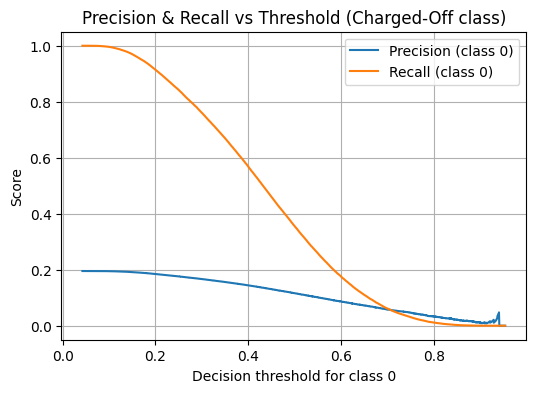

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# y_test  -> true labels   (0 = Charged-Off, 1 = Fully-Paid)
# y_prob  -> model-predicted probability of class 1 (Fully-Paid)
# If you stored P(class 0) instead, use 1-y_prob

precision, recall, thresholds = precision_recall_curve(yTest, 1 - yProb, pos_label=0)

plt.figure(figsize=(6,4))
plt.plot(thresholds, precision[:-1], label='Precision (class 0)')
plt.plot(thresholds, recall[:-1],    label='Recall (class 0)')
plt.xlabel("Decision threshold for class 0")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (Charged-Off class)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
prec, rec, thr = precision_recall_curve(yTest, 1 - yProb, pos_label=0)
f1 = 2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1])
best_thr = thr[f1.argmax()]
print("Best F1 at", best_thr)
y_pred_opt = ((1 - yProb) >= best_thr).astype(int)
print(classification_report(yTest, y_pred_opt))

Best F1 at 0.9410172708503473
              precision    recall  f1-score   support

         0.0       0.20      1.00      0.33     49468
         1.0       1.00      0.00      0.00    203790

    accuracy                           0.20    253258
   macro avg       0.60      0.50      0.16    253258
weighted avg       0.84      0.20      0.06    253258



C:\Users\ty725\AppData\Local\Temp\ipykernel_32020\603765043.py:2: RuntimeWarning: invalid value encountered in divide
  f1 = 2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1])


In [ ]:
thr = 0.55        # example from the plot
y_pred_adj = ((1 - yProb) >= thr).astype(int)
y_pred_adj = pd.DataFrame(y_pred_adj, columns = ['Adjusted'])
show = pd.concat([y_pred_adj, test], axis = 1)
show

,Adjusted,Real Values
0,1,1.0
1,0,1.0
2,0,1.0
3,1,1.0
4,1,1.0
...,...,...
253253,0,1.0
253254,0,0.0
253255,0,0.0
253256,0,1.0


In [ ]:
print(classification_report(yTest, y_pred_adj))

              precision    recall  f1-score   support

         0.0       0.29      0.74      0.42     49468
         1.0       0.90      0.56      0.69    203790

    accuracy                           0.59    253258
   macro avg       0.59      0.65      0.55    253258
weighted avg       0.78      0.59      0.63    253258



## LGD Experimentation

In [ ]:
from pyspark.sql import SparkSession

# Start new session
spark = SparkSession.builder \
    .appName("NewSession") \
    .getOrCreate()

In [ ]:
lgd_df = spark.sql('''
SELECT l.total_pymnt, cd.loan_amnt, cd.int_rate, cd.annual_inc, 
               cd.dti, cd.purpose, cd.fico_range_low, cd.emp_length, cd.grade
FROM loans AS l
JOIN cleanDataset AS cd ON cd.id = l.id
WHERE l.loan_status = 'Charged Off'

''')
lgd_df.show(5)

+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
|total_pymnt|loan_amnt|int_rate|annual_inc|  dti|       purpose|fico_range_low|    emp_length|grade|
+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
|    11632.9|  32200.0|   14.99|   94930.0|16.69|(13,[0],[1.0])|           685|(10,[0],[1.0])|    2|
|    8082.94|  25000.0|   13.49|   98700.0|26.48|(13,[0],[1.0])|           760|(10,[0],[1.0])|    2|
|     4379.7|   8000.0|   17.99|   60880.0|24.94|(13,[0],[1.0])|           730|(10,[0],[1.0])|    3|
|     8283.6|  14000.0|   14.99|   62000.0|24.74|(13,[3],[1.0])|           675|(10,[9],[1.0])|    2|
|    4545.37|  12000.0|   13.99|   95000.0|19.42|(13,[1],[1.0])|           690|(10,[1],[1.0])|    2|
+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col
lgd_df = lgd_df.withColumn('total_pymnt', col('total_pymnt').astype('float'))
lgd_df = lgd_df.na.drop()
lgd_df.show(5)

+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
|total_pymnt|loan_amnt|int_rate|annual_inc|  dti|       purpose|fico_range_low|    emp_length|grade|
+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
|    11632.9|  32200.0|   14.99|   94930.0|16.69|(13,[0],[1.0])|           685|(10,[0],[1.0])|    2|
|    8082.94|  25000.0|   13.49|   98700.0|26.48|(13,[0],[1.0])|           760|(10,[0],[1.0])|    2|
|     4379.7|   8000.0|   17.99|   60880.0|24.94|(13,[0],[1.0])|           730|(10,[0],[1.0])|    3|
|     8283.6|  14000.0|   14.99|   62000.0|24.74|(13,[3],[1.0])|           675|(10,[9],[1.0])|    2|
|    4545.37|  12000.0|   13.99|   95000.0|19.42|(13,[1],[1.0])|           690|(10,[1],[1.0])|    2|
+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
only showing top 5 rows



In [ ]:
lgd_df = lgd_df.withColumnRenamed('loan_amnt', 'EAD')
df = df.withColumnRenamed('total_pymnt', 'Recovery')

In [ ]:
from pyspark.ml.functions import vector_to_array
cols = ['purpose', 'emp_length']
for feature in cols:
    lgd_df = lgd_df.withColumn(feature, vector_to_array(col(feature)))

In [ ]:
lgd_df = lgd_df.toPandas()
lgd_df

,Recovery,EAD,int_rate,annual_inc,dti,purpose,fico_range_low,emp_length,grade
0,11632.900391,32200.0,14.99,94930.0,16.690001,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",685,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
1,8082.939941,25000.0,13.49,98700.0,26.480000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",760,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
2,4379.700195,8000.0,17.99,60880.0,24.940001,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",730,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,8283.599609,14000.0,14.99,62000.0,24.740000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",675,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
4,4545.370117,12000.0,13.99,95000.0,19.420000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",690,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
...,...,...,...,...,...,...,...,...,...
247335,16976.050781,32000.0,13.49,75000.0,19.980000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",660,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
247336,367.329987,2750.0,12.74,14500.0,32.779999,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",675,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
247337,2646.219971,6000.0,17.99,29580.0,16.059999,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",675,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
247338,9046.179688,35000.0,13.99,125000.0,3.960000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",670,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [ ]:
lgd_df['LGD'] = ((lgd_df['EAD'] - lgd_df['Recovery']) / lgd_df['EAD']) 

In [ ]:
lgd_df = expandColumn(lgd_df, 'purpose')
lgd_df = expandColumn(lgd_df, 'emp_length')

In [ ]:
lgd_df = lgd_df.drop(axis = 1, columns = ['Recovery'])
lgd_df

,EAD,int_rate,annual_inc,dti,fico_range_low,grade,LGD,purpose_0,purpose_1,purpose_2,...,emp_length_0,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9
0,32200.0,14.99,94930.0,16.690001,685,2,0.638730,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25000.0,13.49,98700.0,26.480000,760,2,0.676682,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8000.0,17.99,60880.0,24.940001,730,3,0.452537,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14000.0,14.99,62000.0,24.740000,675,2,0.408314,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,12000.0,13.99,95000.0,19.420000,690,2,0.621219,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247335,32000.0,13.49,75000.0,19.980000,660,2,0.469498,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
247336,2750.0,12.74,14500.0,32.779999,675,2,0.866425,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247337,6000.0,17.99,29580.0,16.059999,675,3,0.558963,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247338,35000.0,13.99,125000.0,3.960000,670,2,0.741538,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
capVals = {"EAD" : 35000, "int_rate" : 30, "LGD" : 100, 
           "annual_inc" : 250000, "dti" : 45}

In [ ]:
for key, value in capVals.items():
    lgd_df[key] = lgd_df[key].clip(lower = 0, upper = value)

In [ ]:
X = lgd_df.drop(axis = 1, columns = ['LGD', 'EAD'])
Y = lgd_df['LGD'] / 100

In [ ]:
X = X.to_numpy()
Y = Y.to_numpy()

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size  = 0.2, random_state = 42)

In [ ]:
scaler = StandardScaler()
xTrainS = scaler.fit_transform(xTrain)
xTestS = scaler.transform(xTest)

In [ ]:
from sklearn.linear_model import LinearRegression
lgd_model = LinearRegression()
lgd_model.fit(xTrainS, yTrain)

LinearRegression()

In [ ]:
yPred = lgd_model.predict(xTestS)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(yTest, yPred)
rmse = np.sqrt(mse)
r2 = r2_score(yTest, yPred)
mae = mean_absolute_error(yTest, yPred)

In [ ]:
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.0026
MAE: 0.0022
R²: 0.0286


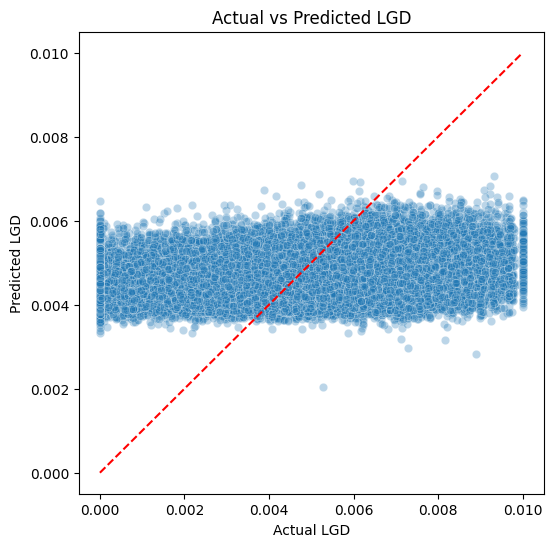

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=yTest, y=yPred, alpha=0.3)
plt.plot([0, 0.01], [0, 0.01], color='red', linestyle='--')  # y = x line
plt.xlabel('Actual LGD')
plt.ylabel('Predicted LGD')
plt.title('Actual vs Predicted LGD')
plt.show()


## Export Model to Azure Machine Learning


In [ ]:
import joblib

In [217]:
joblib.dump(model, "logistic_model.pkl")

['logistic_model.pkl']